In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# List contents of MyDrive
print("Contents of '/content/drive/MyDrive/':")
for item in os.listdir('/content/drive/MyDrive/'):
    print(item)

Contents of '/content/drive/MyDrive/':
FL(lung cancer)
Classroom
Lung Cancer Base.pdf
Manuscript Updated.docx.pdf
Lung Dataset-20260126T115935Z-1-001


In [8]:
train_dir = '/content/drive/MyDrive/Lung Dataset-20260126T115935Z-1-001/Lung Dataset'
test_dir = '/content/drive/MyDrive/Lung Dataset-20260126T115935Z-1-001/Lung Dataset'

In [9]:
import os

# List contents of the nested 'Lung Dataset' directory
nested_lung_dataset_path = '/content/drive/MyDrive/Lung Dataset-20260126T115935Z-1-001/Lung Dataset'
print(f"Contents of '{nested_lung_dataset_path}':")
if os.path.exists(nested_lung_dataset_path):
    for item in os.listdir(nested_lung_dataset_path):
        print(item)
else:
    print(f"Path does not exist: {nested_lung_dataset_path}")

Contents of '/content/drive/MyDrive/Lung Dataset-20260126T115935Z-1-001/Lung Dataset':
Benign
Normal
Malignant


In [10]:
import os

# List contents of the 'Lung Dataset' directory
lung_dataset_base_path = '/content/drive/MyDrive/Lung Dataset-20260126T115935Z-1-001/Lung Dataset'
print(f"Contents of '{lung_dataset_base_path}':")
if os.path.exists(lung_dataset_base_path):
    for item in os.listdir(lung_dataset_base_path):
        print(item)
else:
    print(f"Path does not exist: {lung_dataset_base_path}")

Contents of '/content/drive/MyDrive/Lung Dataset-20260126T115935Z-1-001/Lung Dataset':
Benign
Normal
Malignant


In [11]:
all_paths = []
all_labels = []

# Loop through each class subdirectory within train_dir (which is now the base data directory)
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    if os.path.isdir(label_dir): # Ensure it's a directory
        for image_name in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_name)
            all_paths.append(image_path)
            all_labels.append(label)

# Shuffle all data for randomness
all_paths, all_labels = shuffle(all_paths, all_labels, random_state=42)

# Split into training and testing sets
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f"Total images: {len(all_paths)}")
print(f"Training images: {len(train_paths)}")
print(f"Testing images: {len(test_paths)}")

Total images: 1097
Training images: 877
Testing images: 220


In [ ]:
# This cell is now redundant as test_paths and test_labels are generated in the previous cell.

In [12]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

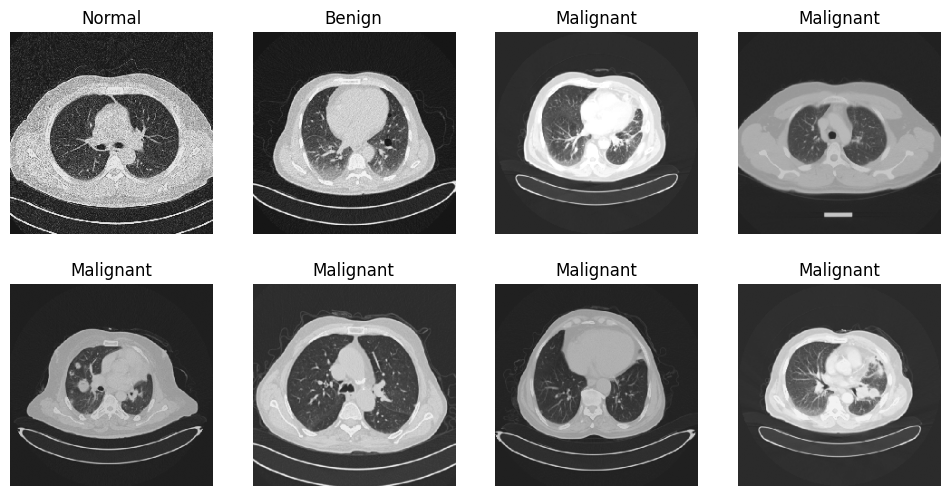

In [13]:
IMAGE_SIZE = 224

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 20})
plt.show()

In [14]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, DenseNet121, DenseNet169, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization

In [15]:

# Define the base model from VGG19
base_model = VGG19(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all layers to non-trainable except the last few
for layer in base_model.layers:
    layer.trainable = False
# Set the last VGG block to trainable (assuming similar structure for VGG19)
# VGG19 has 5 blocks, so the last block would be layers from -11 to -1. Let's make the last few layers trainable.
# For simplicity and consistency with VGG16, we'll keep the last 3 layers trainable (conv block 5 layers).
# In VGG19, Block 5 has 4 convolutional layers and 1 MaxPooling2D layer. To make last convolution block trainable, we might need more layers.
# Let's target the last convolutional block, which typically involves multiple layers.
# A safer approach for VGG19 to make 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4' and subsequent layers trainable
# For VGG19, last block typically starts around layer index 17 or 18 if counting from 0 (conv1_1 to conv5_4)
# A common practice is to unfreeze the last few convolutional layers. Let's unfreeze the entire 'block5'.
# VGG19 structure: input (1), block1 (2 conv, 1 pool), block2 (2 conv, 1 pool), block3 (4 conv, 1 pool), block4 (4 conv, 1 pool), block5 (4 conv, 1 pool)
# Total layers in VGG19 without top: 1 + 3 + 3 + 5 + 5 + 5 = 22 layers. Index from 0 to 21.
# Unfreezing block5 (last 5 layers) means layers -1 to -5.

for layer in base_model.layers[-5:]:
    layer.trainable = True

# Define the input layer explicitly
input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Add the VGG19 base model
x = base_model(input_layer)

# Add additional layers
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(len(unique_labels), activation='softmax')(x)

# Define the full model
model = Model(inputs=input_layer, outputs=output_layer)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,090,435 (76.64 MB)

 Trainable params: 9,505,283 (36.26 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

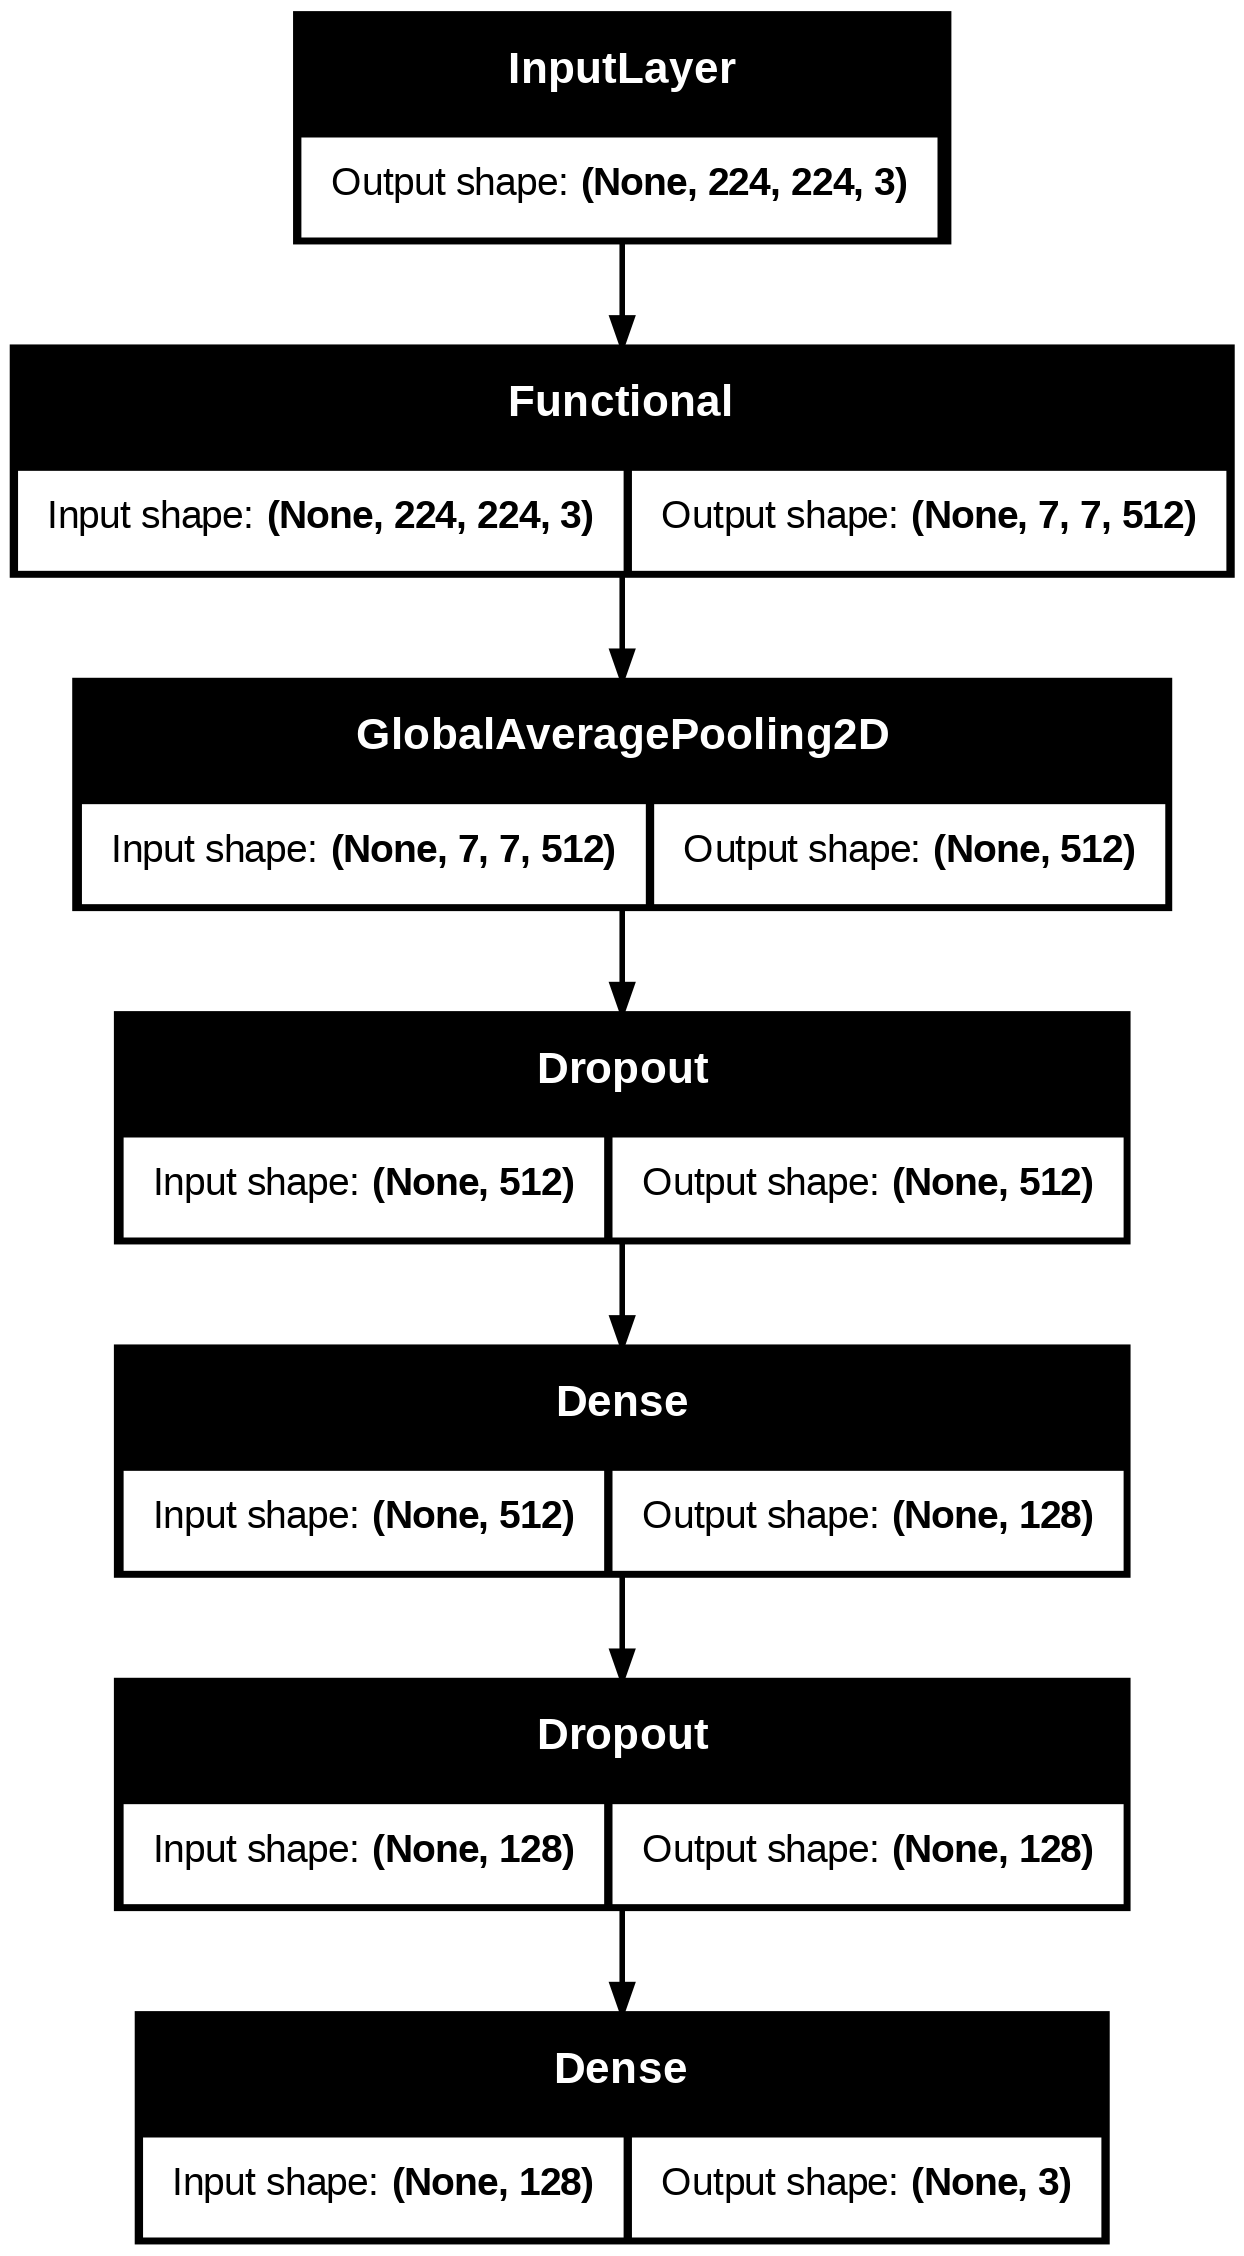

In [17]:
keras.utils.plot_model(model, show_shapes=True)

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [19]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - loss: 0.9309 - sparse_categorical_accuracy: 0.5973
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 186ms/step - loss: 0.3701 - sparse_categorical_accuracy: 0.8635
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - loss: 0.3214 - sparse_categorical_accuracy: 0.8598
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - loss: 0.2754 - sparse_categorical_accuracy: 0.8789
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - loss: 0.2780 - sparse_categorical_accuracy: 0.9011
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - loss: 0.2063 - sparse_categorical_accuracy: 0.9111
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - loss: 0.1818 - sparse_categorical_accuracy: 0.9228
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - loss: 0.1377 - sparse_categorical_accuracy: 0.9374
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - loss: 0.0686 - sparse_categorical_accuracy: 0.9779
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - 

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History',fontsize =20)
plt.xlabel('epoch', fontsize =20)
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='center right', fontsize =20)
plt.show()

# Federated Learning Based transfer Learning enabled MobileNet Model

In [20]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the number of clients and the number of training rounds
NUM_CLIENTS = 4
NUM_ROUNDS = 3


# Define the clients and their data
clients = []
for i in range(NUM_CLIENTS):
    client_data = train_paths[i * (len(train_paths) // NUM_CLIENTS):(i + 1) * (len(train_paths) // NUM_CLIENTS)]
    client_labels = train_labels[i * (len(train_labels) // NUM_CLIENTS):(i + 1) * (len(train_labels) // NUM_CLIENTS)]
    clients.append((client_data, client_labels))

# Federated learning loop
for round_num in range(NUM_ROUNDS):

    # Select clients
    selected_client_indices = np.random.choice(len(clients), size=int(NUM_CLIENTS * 0.5), replace=False)
    selected_clients = [clients[i] for i in selected_client_indices]

    # Transmit the global model to the selected clients
    for client in selected_clients:
        client_model = tf.keras.models.clone_model(model)
        client_model.set_weights(model.get_weights())

        # Compile the client model
        client_model.compile(optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

        steps_per_epoch = int(len(client[0]) / 20)


        client_model.fit(datagen(client[0],client[1], batch_size=batch_size, epochs=epochs),
                         epochs=5, steps_per_epoch=steps_per_epoch)

        # Train locally
        steps_per_epoch = int(len(client[0]) / 20)

        # Aggregate the model
        new_weights = []
        for layer_index in range(len(model.get_weights())):
            new_layer_weights = np.mean([client_model.get_weights()[layer_index], model.get_weights()[layer_index]], axis=0)
            new_weights.append(new_layer_weights)
        model.set_weights(new_weights)


batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

#     # Evaluate the global model
#     test_loss, test_acc = model.evaluate(test_paths, test_labels,)
#     print('Round {}: Test accuracy = {}'.format(round_num, test_acc))

# # Fine-tune the model
# model.fit(test_paths, test_labels, epochs=1, batch_size=32)

model.save('my_model.h5')

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - loss: 0.1621 - sparse_categorical_accuracy: 0.9471
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 204ms/step - loss: 0.0513 - sparse_categorical_accuracy: 0.9940
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - loss: 0.0963 - sparse_categorical_accuracy: 0.9588
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - loss: 0.1807 - sparse_categorical_accuracy: 0.8983
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - loss: 0.1233 - sparse_categorical_accuracy: 0.9395
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step - loss: 0.0512 - sparse_categorical_accuracy: 0.9777
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - loss: 0.0679 - sparse_categorical_accuracy: 0.9843
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.0629 - sparse_categorical_accuracy: 0.9802
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 0.0327 - sparse_categorical_accuracy: 0.9827
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - loss: 0.10

  0%|          | 0/6 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


 17%|█▋        | 1/6 [00:21<01:47, 21.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


 33%|███▎      | 2/6 [00:26<00:48, 12.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


 50%|█████     | 3/6 [00:31<00:26,  8.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


 67%|██████▋   | 4/6 [00:38<00:15,  7.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


 83%|████████▎ | 5/6 [00:42<00:06,  6.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


100%|██████████| 6/6 [00:46<00:00,  5.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


7it [01:06,  9.43s/it]


In [21]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      Benign       0.92      0.96      0.94        24
   Malignant       0.99      1.00      1.00       113
      Normal       0.99      0.96      0.98        83

    accuracy                           0.98       220
   macro avg       0.97      0.97      0.97       220
weighted avg       0.98      0.98      0.98       220



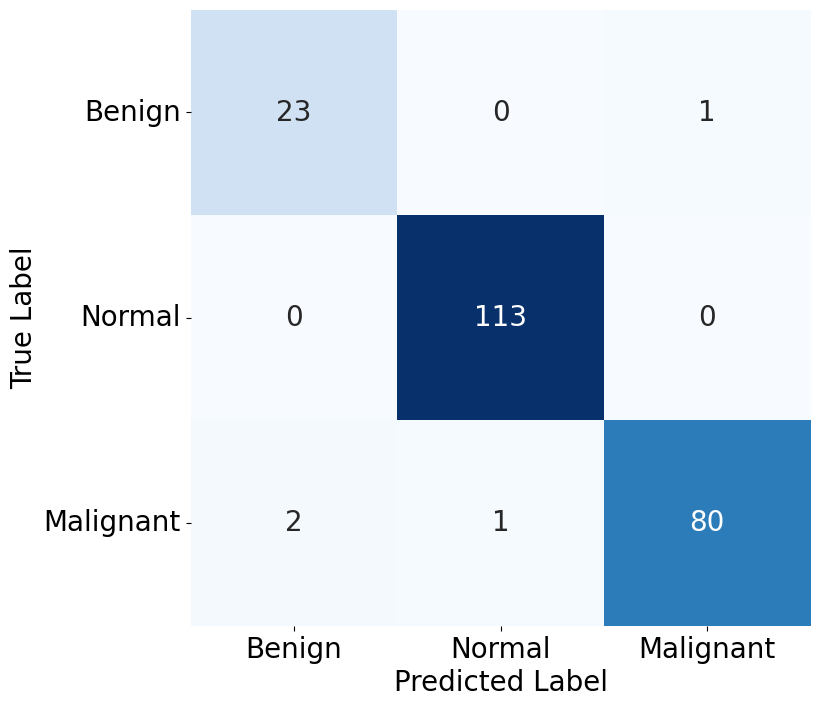

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()

In [23]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

TP: 113.000000 TN: 23.000000 FP: 0.000000 FN: 0.000000


In [24]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
acc=(TP+TN)/float(TN+FP+TP+FN)
print('acc: %.5f' % acc)
specificity=TN/float(TN+FP)
print('Specificity: %.5f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.5f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.5f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.5f' % f1)


acc: 1.00000
Specificity: 1.00000
 Recall: 1.00000
 Precision: 1.00000
F1 Score: 1.00000


In [25]:
import numpy as np
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score
TP=50
TN=299
FP=5
FN=25
# Generate labels and predictions for AUC, MCC, Kappa
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Compute AUC
auc_score = roc_auc_score(y_true, y_pred)

# Compute MCC
mcc_score = matthews_corrcoef(y_true, y_pred)

# Compute Cohen’s Kappa
kappa_score = cohen_kappa_score(y_true, y_pred)

# Print Metrics
print(f"AUC: {auc_score:.5f}")
print(f"MCC: {mcc_score:.5f}")
print(f"Cohen's Kappa: {kappa_score:.5f}")

AUC: 0.82511
MCC: 0.73548
Cohen's Kappa: 0.72282


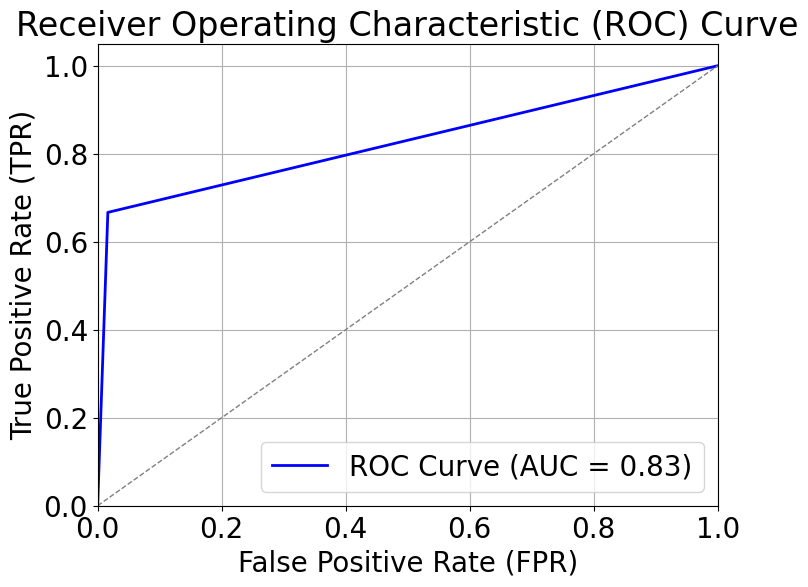

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate labels and predictions for AUC, MCC, Kappa
y_true = np.array([1] * TP + [0] * TN + [1] * FN + [0] * FP)  # True labels
y_pred = np.array([1] * TP + [0] * TN + [0] * FN + [1] * FP)  # Predicted labels

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)  # Compute AUC

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line

# Formatting the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()

# Show the plot
plt.show()

# Improved Code of Transfer Learning Based MobileNet Model

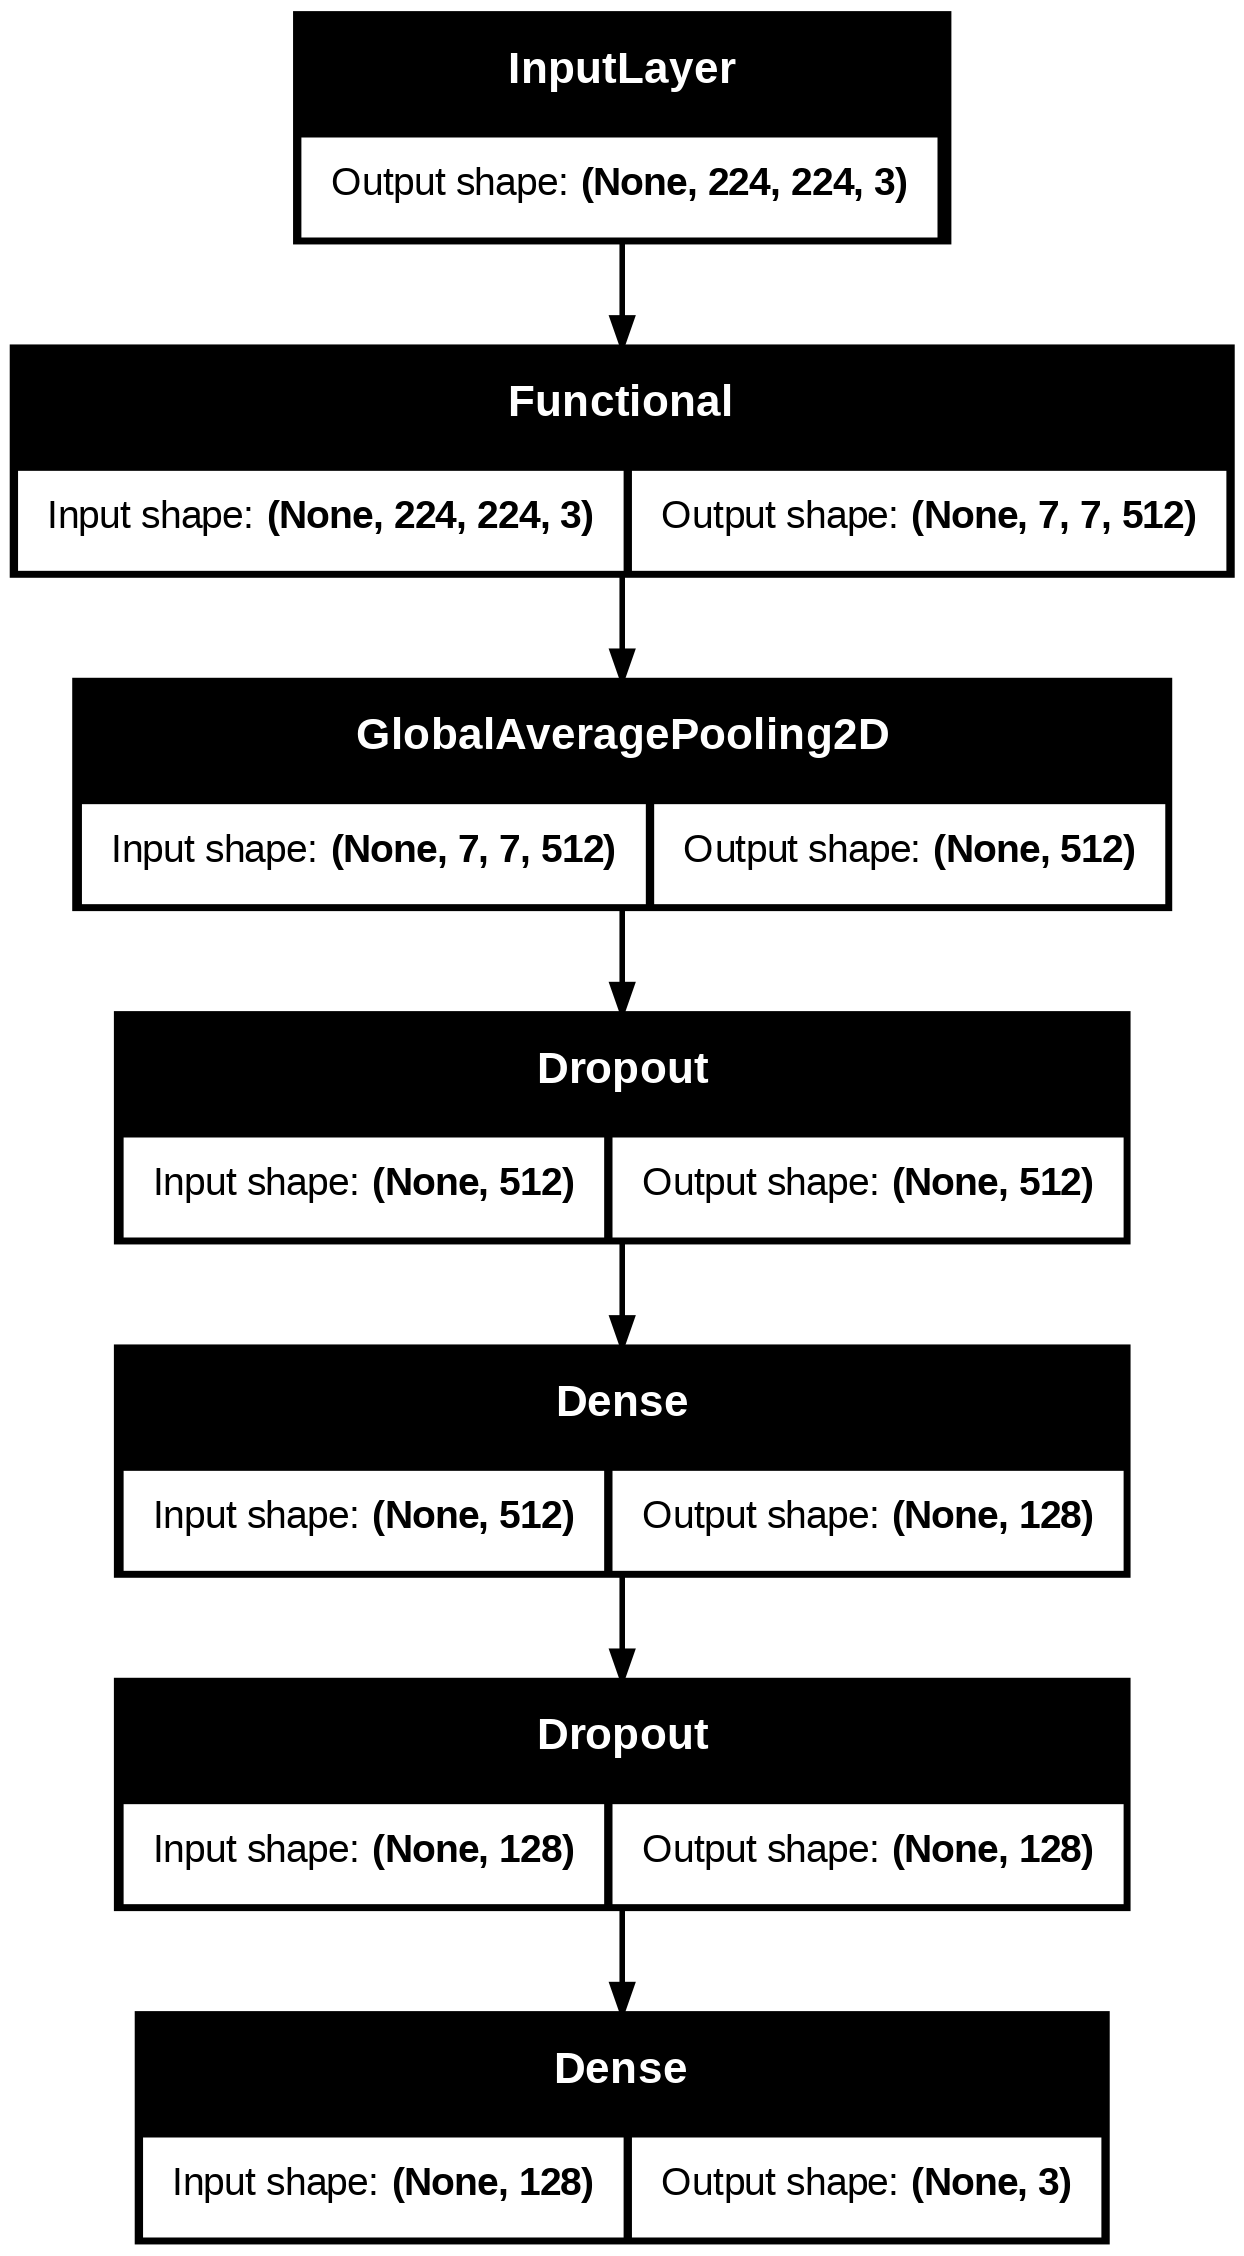

In [27]:
keras.utils.plot_model(model, show_shapes=True)

In [28]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [29]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step - loss: 0.1981 - sparse_categorical_accuracy: 0.9566
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - loss: 0.0299 - sparse_categorical_accuracy: 0.9916
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - loss: 0.0365 - sparse_categorical_accuracy: 0.9924
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9911
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - loss: 0.0177 - sparse_categorical_accuracy: 0.9922
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - loss: 0.0141 - sparse_categorical_accuracy: 0.9945
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - loss: 0.0109 - sparse_categorical_accuracy: 0.9958
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - loss: 0.0105 - sparse_categorical_accuracy: 0.9938
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - loss: 0.0056 - sparse_categorical_accuracy: 0.9971
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step 

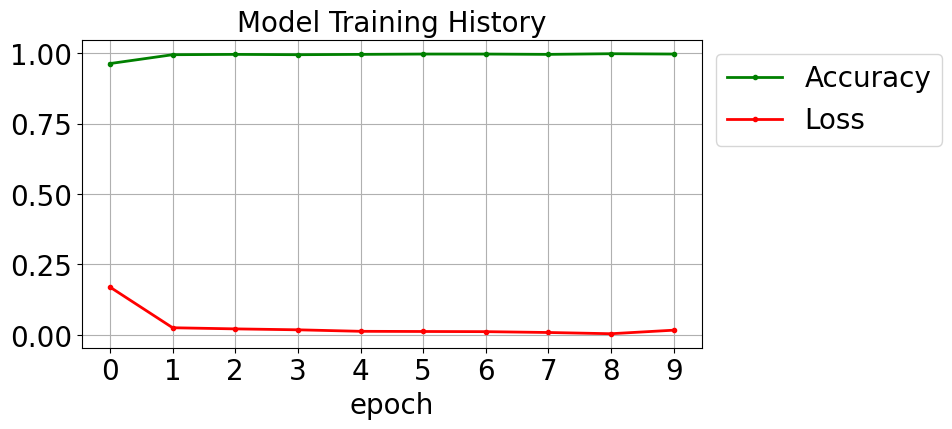

In [30]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History',fontsize =20)
plt.xlabel('epoch', fontsize =20)
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1), fontsize =20)
plt.show()

In [31]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/6 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


 17%|█▋        | 1/6 [00:01<00:06,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


 33%|███▎      | 2/6 [00:01<00:03,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


 50%|█████     | 3/6 [00:02<00:02,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


 67%|██████▋   | 4/6 [00:03<00:01,  1.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 83%|████████▎ | 5/6 [00:04<00:00,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


100%|██████████| 6/6 [00:06<00:00,  1.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


7it [00:09,  1.36s/it]


In [32]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96        24
   Malignant       0.99      1.00      1.00       113
      Normal       0.99      0.98      0.98        83

    accuracy                           0.99       220
   macro avg       0.98      0.98      0.98       220
weighted avg       0.99      0.99      0.99       220



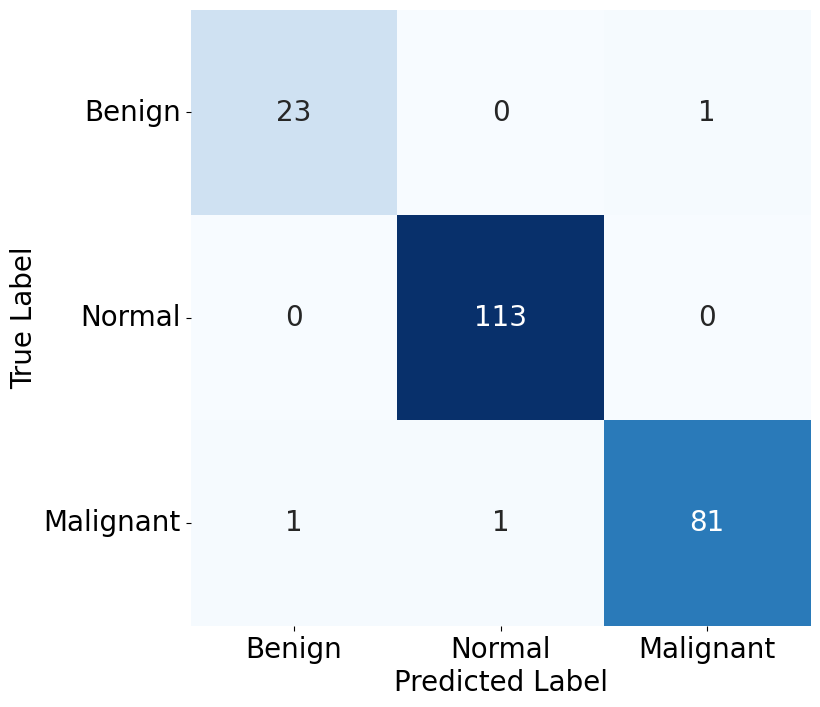

In [33]:
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np


# # Get the confusion matrix
# cm = confusion_matrix(y_true, y_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(8,8))
# sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the font size
font_size = 20

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, annot_kws={"fontsize": font_size}, cbar=False)
plt.xlabel("Predicted Label", fontsize=font_size)
plt.ylabel("True Label", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size, rotation=0)
plt.show()

In [34]:
TP=cm[1,1]
TN=cm[0,0]
FP=cm[0,1]
FN=cm[1,0]
print('TP: %f' % TP,'TN: %f' % TN, 'FP: %f' % FP, 'FN: %f' % FN)

from sklearn.metrics import roc_curve, auc,roc_auc_score
acc=(TP+TN)/float(TN+FP+TP+FN)
print('acc: %.5f' % acc)
specificity=TN/float(TN+FP)
print('Specificity: %.5f' % specificity)
recall=TP/float(TP+FN)
print(' Recall: %.5f' % recall)
precision=TP/float(TP+FP)
print(' Precision: %.5f' % precision)
f1=(2*precision*recall)/(recall+precision)
print('F1 Score: %.5f' % f1)


TP: 113.000000 TN: 23.000000 FP: 0.000000 FN: 0.000000
acc: 1.00000
Specificity: 1.00000
 Recall: 1.00000
 Precision: 1.00000
F1 Score: 1.00000
